In [ ]:
import numpy as np
from tensorflow.core.example.example_pb2 import Example
from tensorflow.core.example.feature_pb2 import Feature
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd
import shap
import sklearn
from keras.layers import Input, Dense, Flatten, \
    Concatenate, concatenate, Dropout, Lambda
from keras.models import Model, Sequential
from keras.layers.embeddings import Embedding
import keras
from livelossplot import PlotLossesKeras
import math


shap.initjs()



# Census income classification with Keras

We use keras to perform this computation


In [ ]:
# tmp_df = df.load_csv()

X,y = shap.datasets.adult()
X_display,y_display = shap.datasets.adult(display=True)


input_features = ["age", "workclass", "education-num", "marital-status",
                   "occupation", "relationship", "ethnicity", "gender", "capital-gain", "capital-loss",
                   "hours-per-week", "native-country"]

categorical_features = ["workclass", "marital-status",
                       "occupation", "relationship", "ethnicity", "gender",
                       "native-country"]

X.columns = input_features
X_display.columns = input_features


# ethnicity, workclass, capital-loss, gender
del X["ethnicity"]
del X_display["ethnicity"]
# del X["workclass"]
# del X_display["workclass"]
# del X["capital-loss"]
# del X_display["capital-loss"]
del X["gender"]
del X_display["gender"]

# normalize data (this is important for model convergence)
dtypes = list(zip(X.dtypes.index, map(str, X.dtypes)))
for k,dtype in dtypes:
    if dtype == "float32":
        X[k] -= X[k].mean()
        X[k] /= X[k].std()

X_train, X_valid, y_train, y_valid = \
    train_test_split(X, y, test_size=0.2, random_state=7)

X_train.head(5)

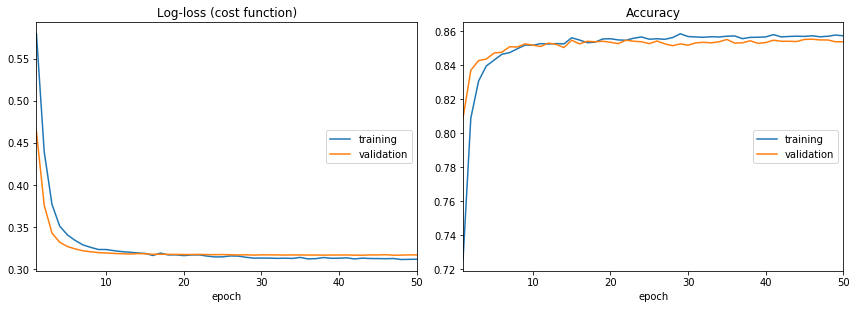

Log-loss (cost function):
training   (min:    0.311, max:    0.579, cur:    0.312)
validation (min:    0.316, max:    0.463, cur:    0.317)

Accuracy:
training   (min:    0.726, max:    0.858, cur:    0.857)
validation (min:    0.809, max:    0.855, cur:    0.854)


In [369]:
# Defining model as functional type

input_els = []
encoded_els = []
for k,dtype in dtypes:
    input_els.append(Input(shape=(1,)))
    if dtype == "int8":
        e = Flatten()(Embedding(X_train[k].max()+1, 1)(input_els[-1]))
    else:
        e = input_els[-1]
    encoded_els.append(e)
encoded_els = concatenate(encoded_els)

layer1 = Dropout(0.5)(Dense(100, activation="relu")(encoded_els))
out = Dense(1, activation='sigmoid')(layer1)

# train model
model = Model(inputs=input_els, outputs=[out])
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

x_train_proc = [X_train[k].values for k,t in dtypes]
x_valid_proc = [X_valid[k].values for k,t in dtypes]

model.fit(
    x_train_proc,
    y_train,
    epochs=50,
    batch_size=512,
    shuffle=True,
    validation_data=(x_valid_proc, y_valid),
    callbacks=[PlotLossesKeras()],
    verbose=0,
    validation_split=0.05,
)

In [ ]:
input_test = [X.iloc[:,i] for i in range(X.shape[1])]
score = model.evaluate(input_test, y, verbose=1)
# print(list(predictions.T[0]))
# ??np.argmax
print(score)

In [ ]:
input_test = [X_valid.iloc[:,i] for i in range(X.shape[1])]
probabilities = model.predict(input_test)
print(list(probabilities.T[0])[:10])
# print(list(predictions.T[1])[:10])

In [ ]:
pred = list((probabilities >= 0.5).astype(int).T[0])
print(pred[:10])

In [ ]:
print(sklearn.metrics.classification_report(y_valid, pred))

print("\nF1 Score:", sklearn.metrics.f1_score(y_valid, pred))

print("\nAccuracy:", sklearn.metrics.accuracy_score(y_valid, pred))

In [ ]:

confusion = sklearn.metrics.confusion_matrix(
    y_valid,
    pred)


confusion_df = pd.DataFrame(confusion,
            index=["Actual Denied", "Actual Approved"], 
            columns=["Preditced Denied", "Preditced Approved"])

confusion_scaled = \
    confusion.astype("float") / confusion.sum(axis=1)[:, np.newaxis]

confusion_scaled_df = pd.DataFrame(confusion_scaled, 
            index=["Denied", "Approved"], 
            columns=["Denied", "Approved"])

sn.heatmap(confusion_df, annot=True, fmt='d', center=1)
plt.show()

sn.heatmap(confusion_scaled_df, annot=True, fmt='.2f', center=1)
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(
        y_valid, pred)

roc_auc = auc(fpr, tpr)
print(roc_auc)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Learning curves

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def f(X, m=None):
    if m:
        return [X.iloc[:m,i] for i in range(X.shape[1])]
    else:
        return [X.iloc[:,i] for i in range(X.shape[1])]

def f_conv(probs):
    return list((probs >= 0.5).astype(int).T[0])

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in list(np.logspace(0.6,4,dtype='int')):
        if m >= len(X_train): break
        model.fit(f(X_train,m), y_train[:m], epochs=50, batch_size=512, verbose=0)
        y_train_predict = model.predict(f(X_train,m))
        y_val_predict = model.predict(f(X_val))
        y_train_predict = f_conv(y_train_predict)
        y_val_predict = f_conv(y_val_predict)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")

plot_learning_curves(model, X_valid, y_valid)

In [ ]:
def shap_predict(X):
    values = model.predict([X[:,i] for i in range(X.shape[1])]).flatten()
    return values

shap_explainer = shap.KernelExplainer(shap_predict, X.iloc[:100,:])

In [ ]:
shap_idx = 0
shap_x = X.iloc[shap_idx,:]
shap_display_x = X_display.iloc[shap_idx,:]
shap_values = shap_explainer.shap_values(shap_x, nsamples=500)

In [ ]:
print("Probability: ", probabilities[shap_idx])
shap.force_plot(shap_explainer.expected_value, shap_values, shap_display_x)

In [ ]:
shap_idx_multi_from = 15
shap_idx_multi_to = 40

In [ ]:
shap_x_multi = X.iloc[shap_idx_multi_from:shap_idx_multi_to,:]
shap_display_multi = X_display.iloc[shap_idx_multi_from:shap_idx_multi_to,:]
shap_y_multi = y[shap_idx_multi_from:shap_idx_multi_to]

In [ ]:
shap_values_multi = shap_explainer.shap_values(shap_x_multi, nsamples=500)

In [ ]:
shap.force_plot(shap_explainer.expected_value, shap_values_multi, shap_display_multi)


In [ ]:
shap.dependence_plot("gender", 
                     shap_values_multi, 
                     shap_x_multi, 
                     display_features=shap_display_multi)

In [ ]:
shap.summary_plot(shap_values_multi, shap_x_multi)

# LIME on Keras+Tensorflow

In [ ]:
from lime.lime_tabular import LimeTabularExplainer

In [ ]:
tf_lime_explainer = LimeTabularExplainer(
                X_train.values,
                feature_names=list(X_train.columns),
                categorical_features=categorical_features)

In [ ]:
def lime_predict_proba(X):
    values = model.predict([X[:,i] for i in range(X.shape[1])]).flatten()
    prob_pairs = np.array([1-values, values]).T
    return prob_pairs

tf_lime_explanation = tf_lime_explainer.explain_instance(
        X_train.iloc[1,:], lime_predict_proba, num_features=13) 

In [ ]:
tf_lime_explanation.as_list()

In [ ]:
tf_lime_explanation.as_pyplot_figure()

In [ ]:
tf_lime_explanation.show_in_notebook(show_table=True, show_all=True)

# Data Analysis

In [ ]:
target_column = "loan"
df = X_display.copy()
df[target_column] = y_display.astype(np.int8)

In [ ]:
cat_columns = df.select_dtypes(['category']).columns
df[cat_columns] = df[cat_columns].astype(str)

In [ ]:
df[target_column].value_counts().plot.barh()

In [ ]:
fig = plt.figure(figsize=(20,15))
cols = 5
rows = math.ceil(float(df.shape[1]) / cols)
for i, column in enumerate(df.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if df.dtypes[column] == np.object:
        df[column].value_counts().plot(kind="bar", axes=ax)
    else:
        df[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

In [ ]:
df["gender"].value_counts().plot.barh()

In [ ]:
flds = ["gender", "age", "education-num", "capital-gain", 
                  "capital-loss", "hours-per-week"]


enc_summ = X_display[flds].groupby("gender", as_index=False).mean()
enc_summ

In [ ]:
df["ethnicity"].value_counts().plot.barh()

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance


In [ ]:
def keras_score(self, X, y, **kwargs):
    input_test = [X[:,i] for i in range(X.shape[1])]
    loss = self.evaluate(input_test, y)
    if type(loss) is list:
        # The first one is the error, the rest are metrics
        return -loss[0]
    return -loss

perm = PermutationImportance(model, random_state=1, scoring=keras_score).fit(X,y)

In [ ]:
eli5.show_weights(perm, feature_names = X.columns.tolist())

In [ ]:
eli5_fi = eli5.explain_weights_df(perm, feature_names = X.columns.tolist())
eli5_fi

In [ ]:
eli5_fi.plot("feature", "weight", "barh", figsize=(12,7))

# Sit down with our clients to understand these perspectives